* Data Selection: master.CCV - https://www.transit.dot.gov/ntd/data-product/monthly-module-raw-data-release
* Data Preprocessing: data cleaning and data formating for utilization for making new variables
    * Added numeric values to new data frame to make correlation matrix of numeric values.


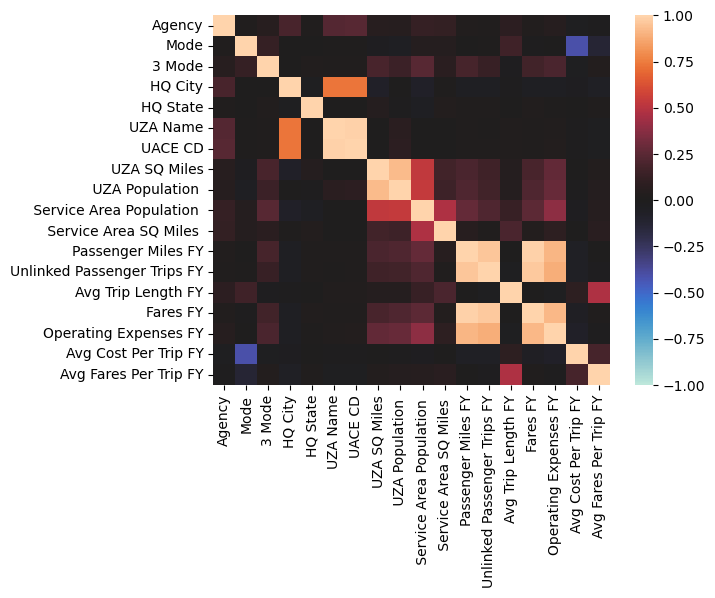

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

"""
file reading resulted in an error. encoding iso fixed the issue reading unkown character
"""
df = pd.read_csv("master.csv", encoding = "ISO-8859-1")

df[' UZA Population '] = df[' UZA Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' UZA Population '] = pd.to_numeric(df[' UZA Population '], errors='coerce')

df[' Service Area Population '] = df[' Service Area Population '].str.replace('-', '0')
df[' Service Area Population '] = df[' Service Area Population '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area Population '] = pd.to_numeric(df[' Service Area Population '], errors='coerce')

df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace('-', '0')
df[' Service Area SQ Miles '] = df[' Service Area SQ Miles '].str.replace(r'[^0-9]', '', regex=True).astype(float)
df[' Service Area SQ Miles '] = pd.to_numeric(df[' Service Area SQ Miles '], errors='coerce')

df['Operating Expenses FY'] = df['Operating Expenses FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Operating Expenses FY'] = pd.to_numeric(df['Operating Expenses FY'], errors='coerce')
df['Operating Expenses FY'] = df['Operating Expenses FY'] / 100

df['Fares FY'] = df['Fares FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Fares FY'] = pd.to_numeric(df['Fares FY'], errors='coerce')
df['Fares FY'] = df['Fares FY'] / 100

df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Fares Per Trip FY'] = pd.to_numeric(df['Avg Fares Per Trip FY'], errors='coerce')
df['Avg Fares Per Trip FY'] = df['Avg Fares Per Trip FY'] / 100

df['Unlinked Passenger Trips FY'] = df['Unlinked Passenger Trips FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Unlinked Passenger Trips FY'] = pd.to_numeric(df['Unlinked Passenger Trips FY'], errors='coerce')

df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'].str.replace(r'[^0-9]', '', regex=True).astype(float)
df['Avg Cost Per Trip FY'] = pd.to_numeric(df['Avg Cost Per Trip FY'], errors='coerce')
df['Avg Cost Per Trip FY'] = df['Avg Cost Per Trip FY'] / 100

df['Passenger Miles FY'] = df['Passenger Miles FY'].str.replace(r'[^0-9]', '', regex=True)
df['Passenger Miles FY'] = pd.to_numeric(df['Passenger Miles FY'], errors='coerce')
df = df[df['Passenger Miles FY'] != 0]
df = df[~(df['Status'].isna() | (df['Status'] == 'Inactive'))]
#df['Revenue'] = (df['Fares FY'] * df['Unlinked Passenger Trips FY']) - df['Operating Expenses FY']
#df['Revenue'] = df['Fares FY'] - df['Operating Expenses FY']

df = df[~(df['HQ City'].isna())]

#print(df['Status'])
#print(df['Revenue'])

df.drop(columns = ['NTD ID', 'Legacy NTD ID', 'TOS', 'Status', 'Reporter Type', 'Organization Type', 
                   'Most Recent Report Year', 'FY End Month', 'FY End Year'])
string_feats = ['Agency', 'Mode', '3 Mode', 'HQ City', 'HQ State', 'UZA Name']
df_string_feats = df[string_feats]

for feat in string_feats:
    df[feat] = df[feat].astype('category').cat.codes

df_1 = df[['Agency', 'Mode', '3 Mode', 'HQ City','HQ State', 'UZA Name', 'UACE CD', 'UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 
           ' Service Area SQ Miles ', 'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 
           'Operating Expenses FY', 'Avg Cost Per Trip FY', 'Avg Fares Per Trip FY']]
corr_matrix = df_1.corr()
corr_matrix.round(2)

sns.heatmap(corr_matrix, vmin = -1, vmax = 1, center = 0)
plt.show()

df[string_feats] = df_string_feats

#to do
#visualize each feature to better decide on a model (box and whisker diagrams)
#map different states to regions or numbers
#two models (tree, oner or naive bayes)
#cross-validation
#accuracy (ROC curve, precision/recall curve)

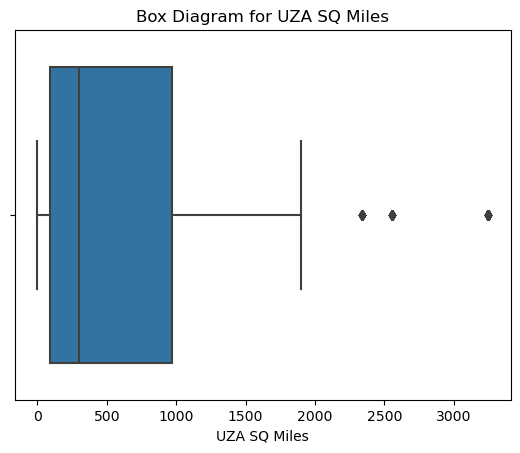

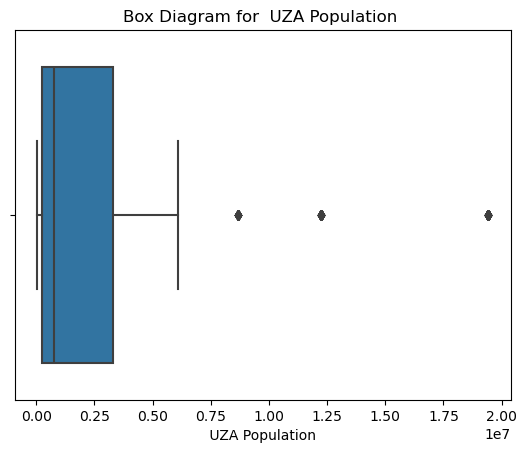

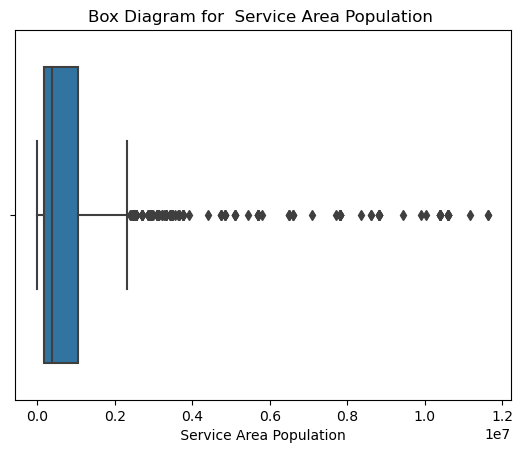

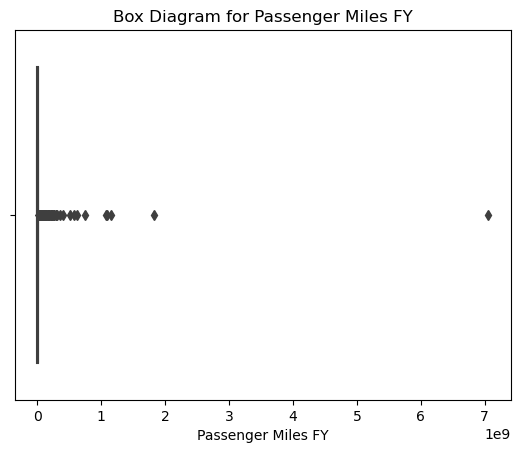

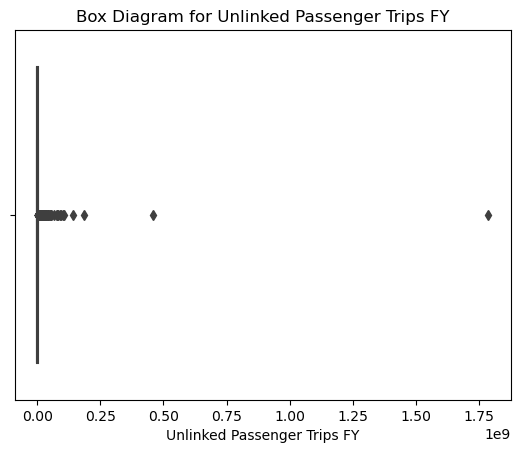

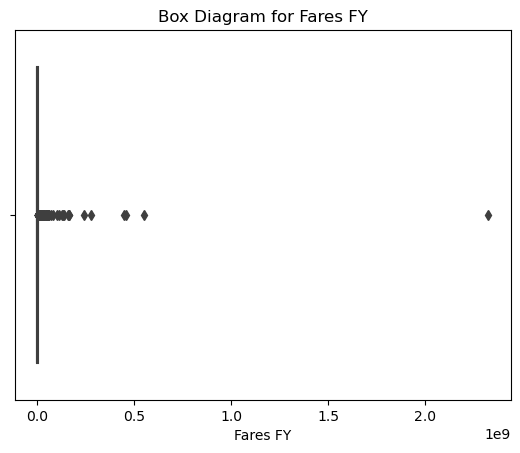

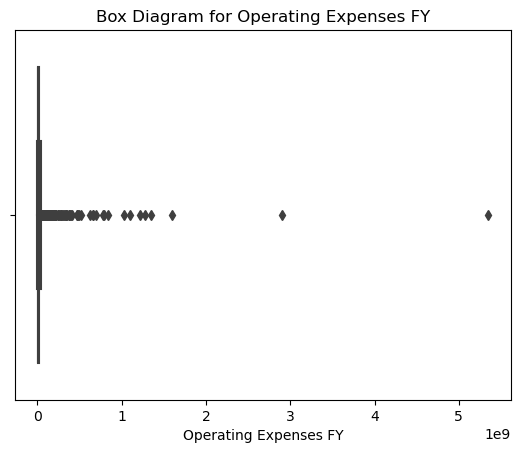

In [82]:
#visualize each feature to better decide on a model (box and whisker diagrams)
features = df[['UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 'Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Fares FY', 
           'Operating Expenses FY']]

def show_histograms():
    for feature in features:
        plt.figure()
        sns.boxplot(x=feature, data=df)
        plt.title(f'Box Diagram for {feature}')
        plt.show()

show_histograms()
#plt.savefig("imagename.png")

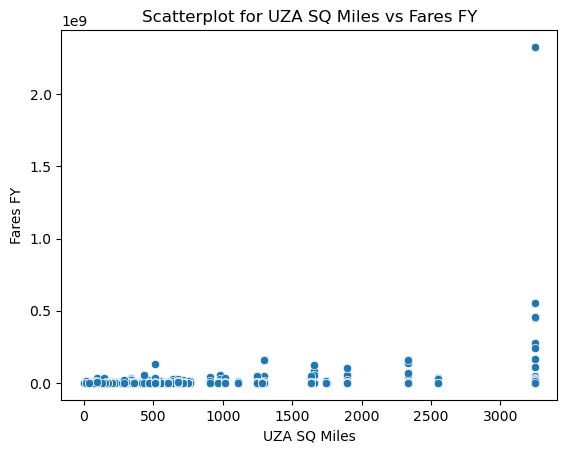

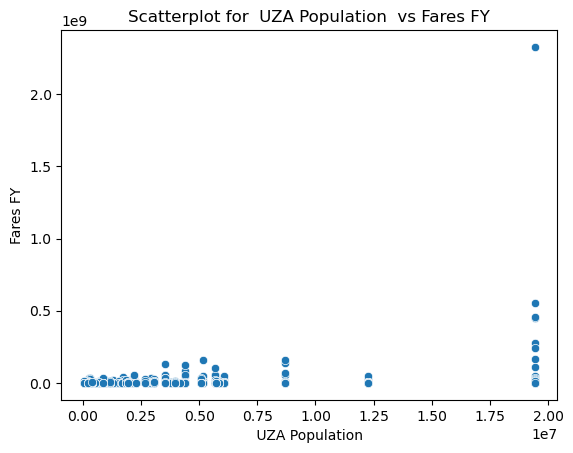

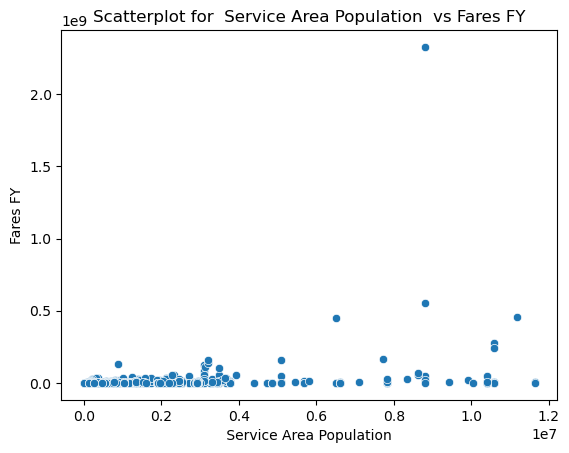

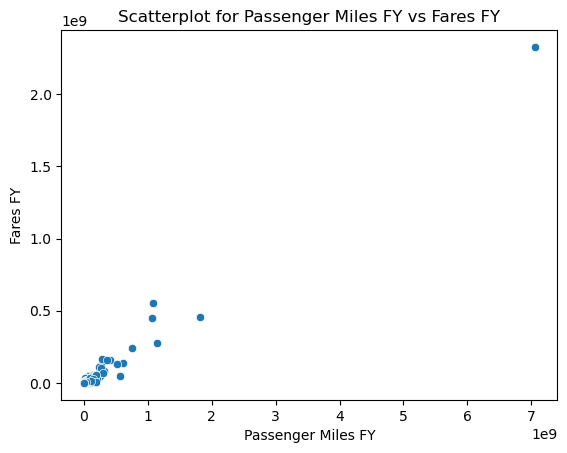

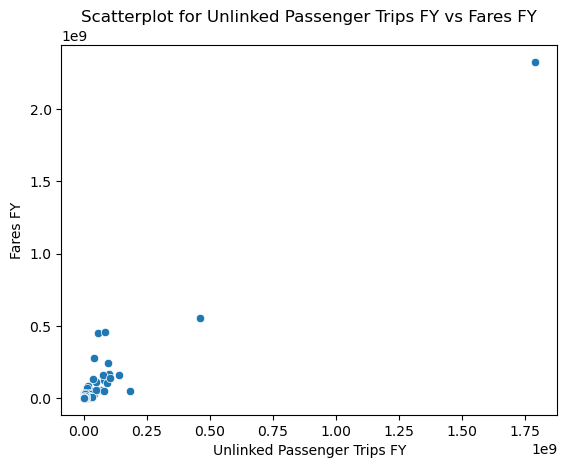

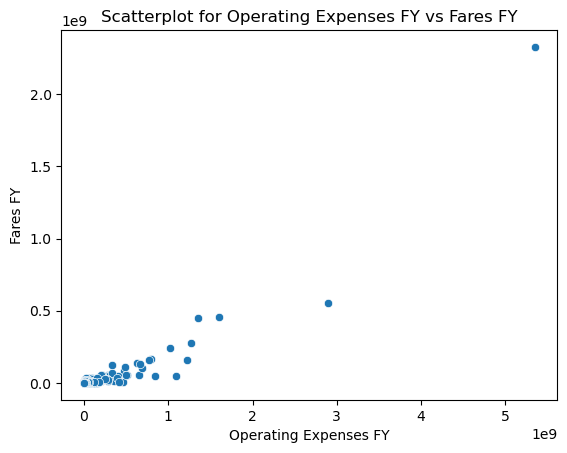

In [83]:
# making the scatterPlot for the making of the features

def show_scatter():
    for feature in features:
        if feature != 'Fares FY':
            plt.figure()
            sns.scatterplot(x=feature, y='Fares FY', data=df)
            plt.title(f'Scatterplot for {feature} vs Fares FY')
            plt.show()

show_scatter()

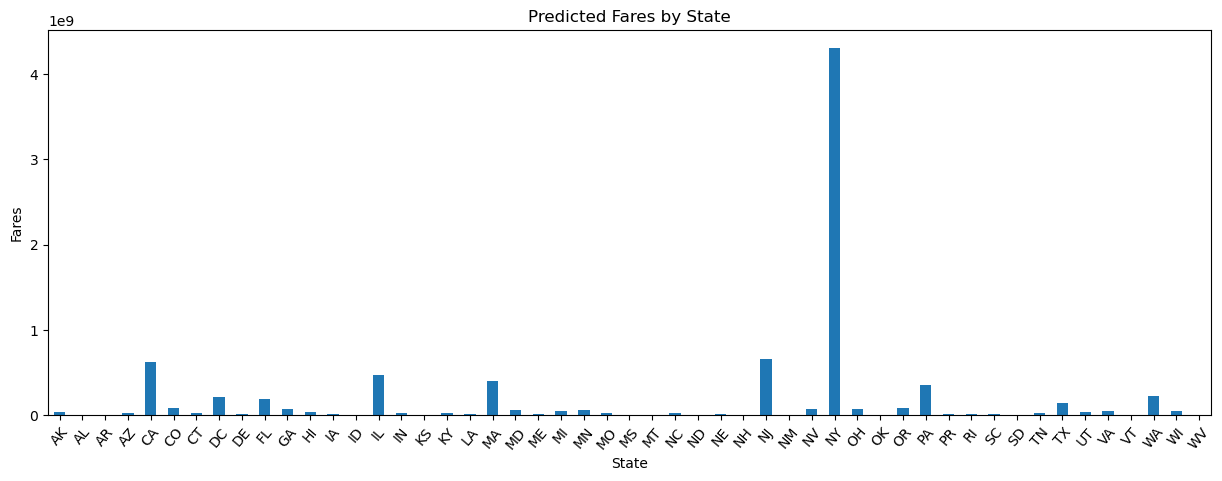

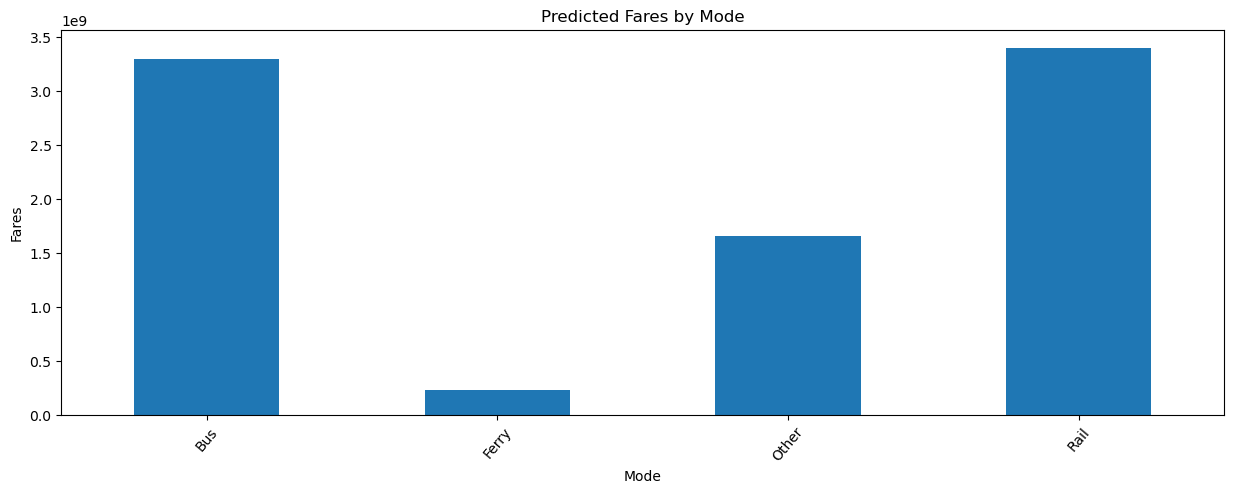

In [84]:
state_revenue = df.groupby('HQ State')['Fares FY'].sum()
# Creating a bar graph of the predicted revenue
plt.figure(figsize=(15, 5))
state_revenue.plot(kind='bar')
plt.title('Predicted Fares by State')
plt.xlabel('State')
plt.ylabel('Fares')
plt.xticks(rotation=50)
plt.show()

mode_revenue = df.groupby('3 Mode')['Fares FY'].sum()
plt.figure(figsize=(15, 5))
mode_revenue.plot(kind='bar')
plt.title('Predicted Fares by Mode')
plt.xlabel('Mode')
plt.ylabel('Fares')
plt.xticks(rotation=50)
plt.show()

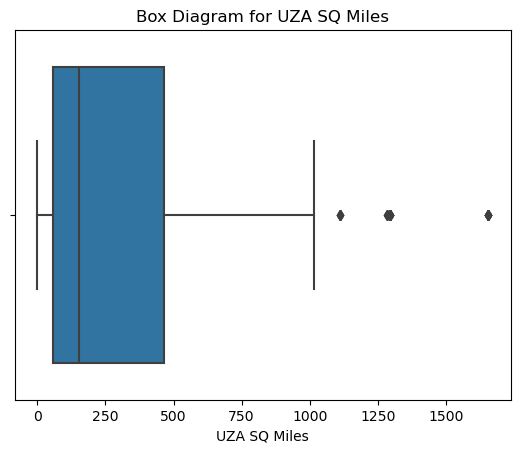

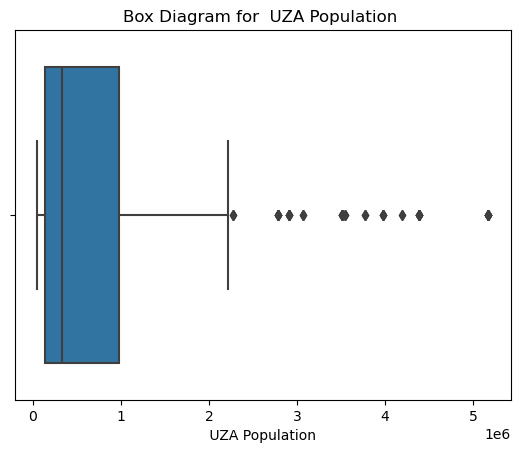

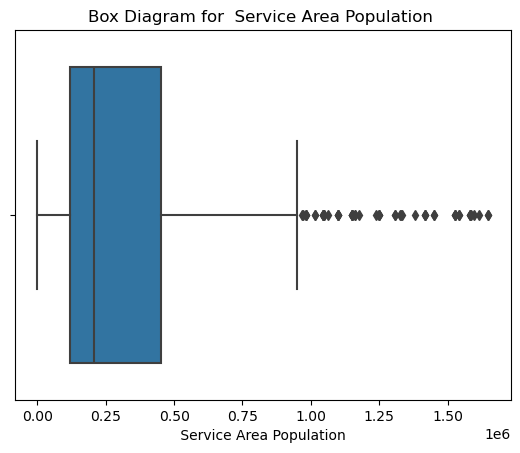

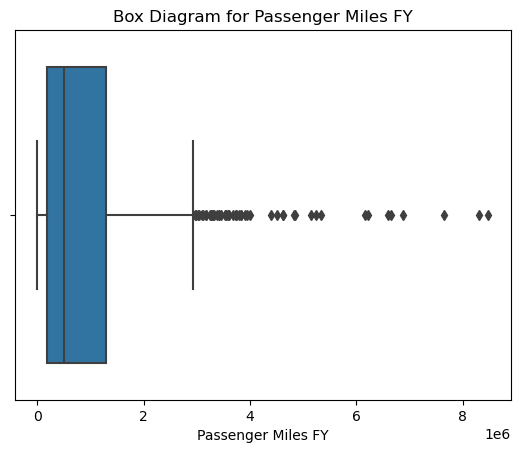

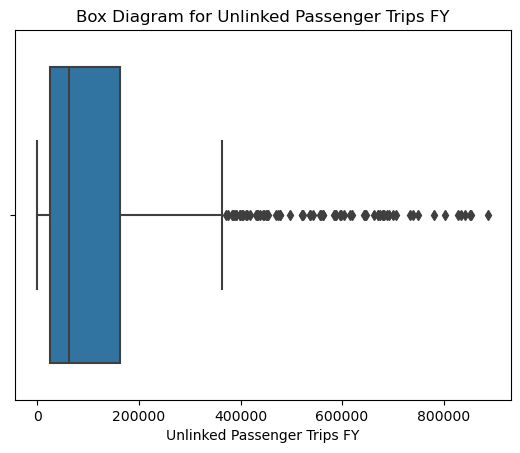

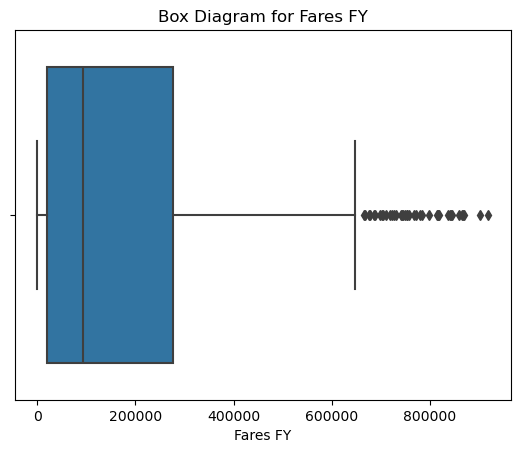

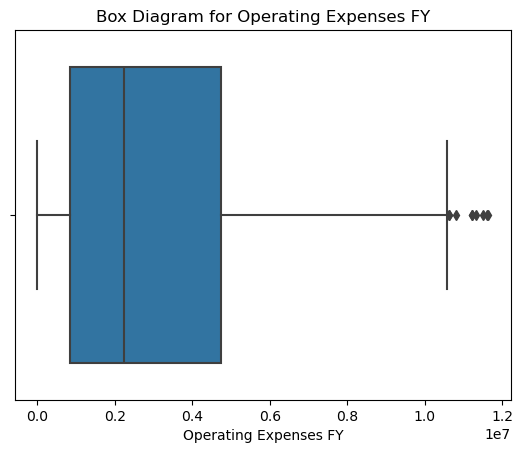

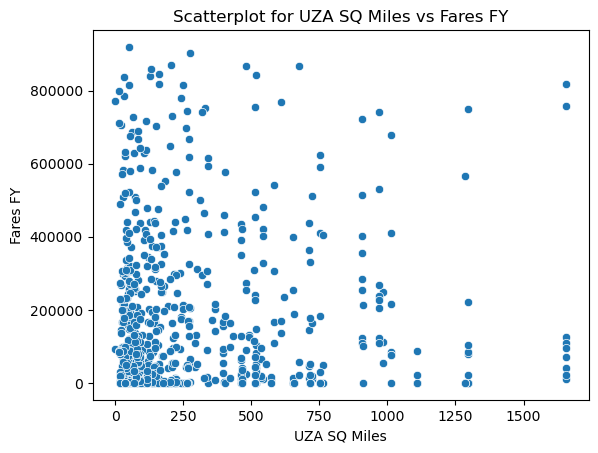

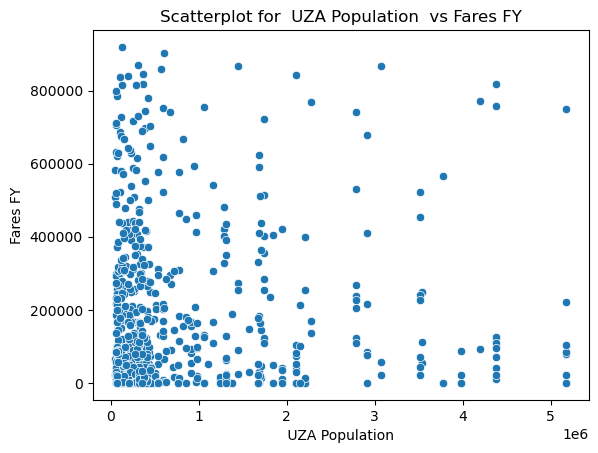

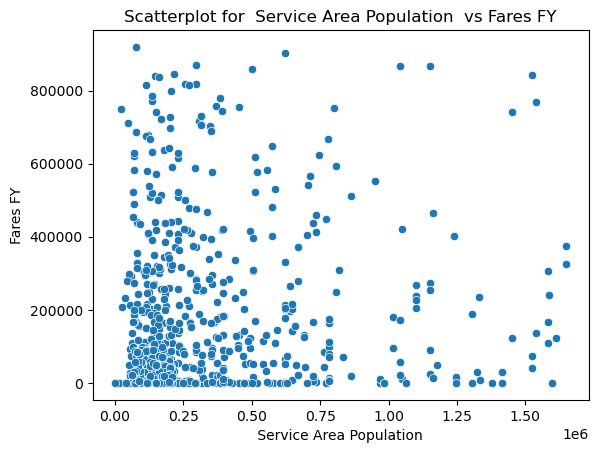

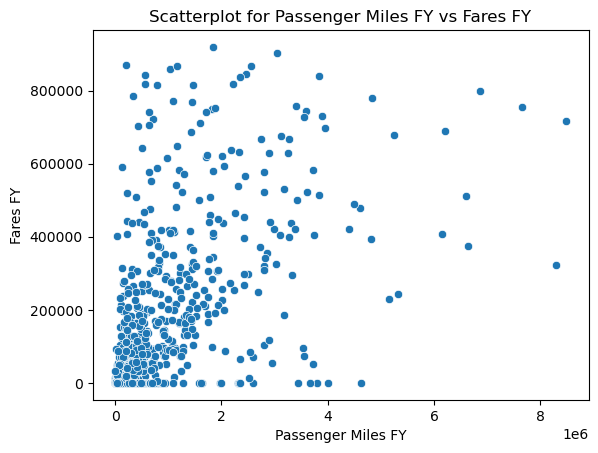

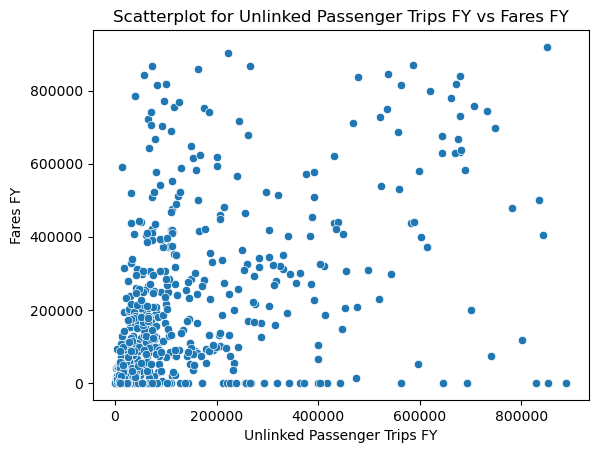

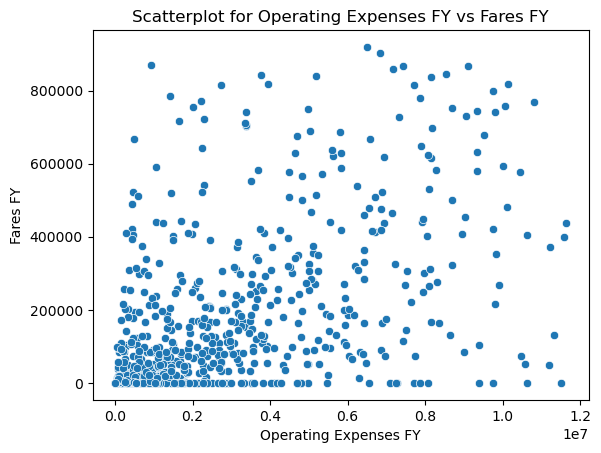

In [85]:
for feature in features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    df = df[df[feature] < q3 + 1.5 * iqr]
    df = df[df[feature] > q1 - 1.5 * iqr]

show_histograms()
show_scatter()

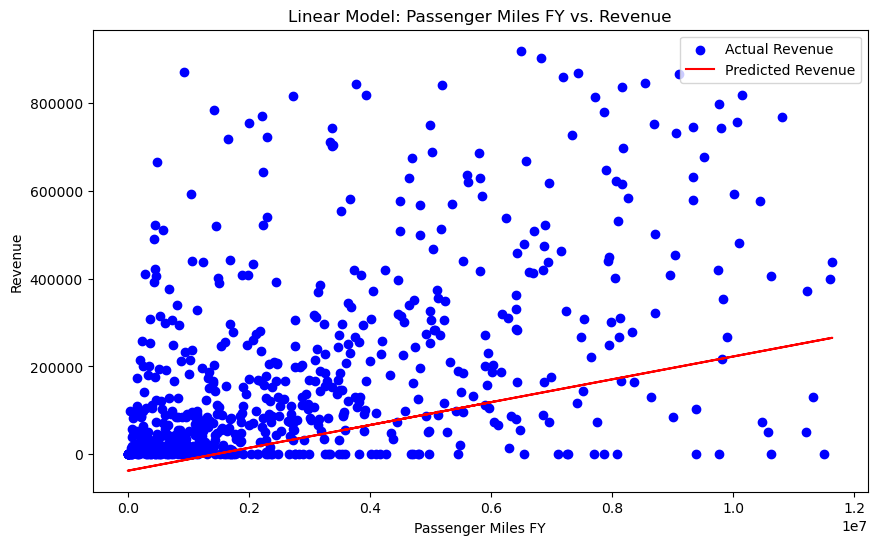

"\nfeatures = df[['UZA SQ Miles',' Service Area Population ', 'Passenger Miles FY',\n          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', \n            'Avg Fares Per Trip FY']]\ntree_model = DecisionTreeClassifier(criterion = 'entropy', ccp_alpha = 0.01, min_samples_split = 100)\nx_train, x_test, y_train, y_test = train_test_split(features, df['Is Profitable'], test_size = 0.33, random_state = 25)\ntree_model.fit(x_train, y_train)\ntree_pred = tree_model.predict(x_test)\n\nfrom sklearn.tree import plot_tree\nfrom sklearn.metrics import accuracy_score\n# Plotting the decision tree for Unlinked Passenger Trips FY vs. Revenue\nplt.figure(figsize=(20, 15))\nplot_tree(tree_model, filled=True, feature_names=['UZA SQ Miles',' Service Area Population ', 'Passenger Miles FY',\n          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', \n            'Avg Fares 

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

'''
high_correlation_feats = df[['Passenger Miles FY', 'Unlinked Passenger Trips FY', 'Fares FY', 'Operating Expenses FY']]
high_correlation_feats = high_correlation_feats.values.reshape(-1, 4)
revenues = df['Revenue'].values.reshape(-1, 1)

linear_model = LinearRegression()
linear_model.fit(high_correlation_feats, revenues)

linear_train_x, linear_test_x, linear_train_y, linear_test_y = train_test_split(high_correlation_feats, revenues, test_size = 0.33, random_state = 25)
pred_revenue_linear = linear_model.predict(linear_test_x)
'''

high_correlation_feats = df[['UZA SQ Miles', ' UZA Population ', ' Service Area Population ', 'Passenger Miles FY', 
                             'Unlinked Passenger Trips FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', 'Avg Fares Per Trip FY']]
high_correlation_feats = high_correlation_feats.to_numpy()
fares = df['Fares FY'].to_numpy()
multi_linear_model = LinearRegression()
multi_linear_model.fit(high_correlation_feats.reshape(-1, 8), fares)
pred = multi_linear_model.predict(high_correlation_feats.reshape(-1, 8))

x_delta = np.linspace(high_correlation_feats[:, 5].min(), 
                      high_correlation_feats[:, 5].max(), 
                      high_correlation_feats[:, 5].shape[0])
y_delta = np.linspace(pred.min(), pred.max(), pred.shape[0])
tester = []
for i in range(len(pred)):
    tester.append((multi_linear_model.coef_[5] * high_correlation_feats[i, 5]) + multi_linear_model.intercept_)

plt.figure(figsize=(10, 6))
plt.scatter(high_correlation_feats[:, 5], fares, color='blue', label='Actual Revenue')
plt.plot(high_correlation_feats[:, 5], tester, color='red', label='Predicted Revenue')
plt.title('Linear Model: Passenger Miles FY vs. Revenue')
plt.xlabel('Passenger Miles FY')
plt.ylabel('Revenue')
plt.legend()
plt.show()

'''
features = df[['UZA SQ Miles',' Service Area Population ', 'Passenger Miles FY',
          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', 
            'Avg Fares Per Trip FY']]
tree_model = DecisionTreeClassifier(criterion = 'entropy', ccp_alpha = 0.01, min_samples_split = 100)
x_train, x_test, y_train, y_test = train_test_split(features, df['Is Profitable'], test_size = 0.33, random_state = 25)
tree_model.fit(x_train, y_train)
tree_pred = tree_model.predict(x_test)

from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
# Plotting the decision tree for Unlinked Passenger Trips FY vs. Revenue
plt.figure(figsize=(20, 15))
plot_tree(tree_model, filled=True, feature_names=['UZA SQ Miles',' Service Area Population ', 'Passenger Miles FY',
          'Unlinked Passenger Trips FY', 'Avg Trip Length FY', 'Fares FY', 'Operating Expenses FY', 'Avg Cost Per Trip FY', 
            'Avg Fares Per Trip FY'], class_names = ['0', '1'], fontsize=6)
plt.show()
acc_score = accuracy_score(y_test, tree_pred)

from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)
nb_pred = naive_bayes.predict(x_test)
print(accuracy_score(y_test, nb_pred))
'''

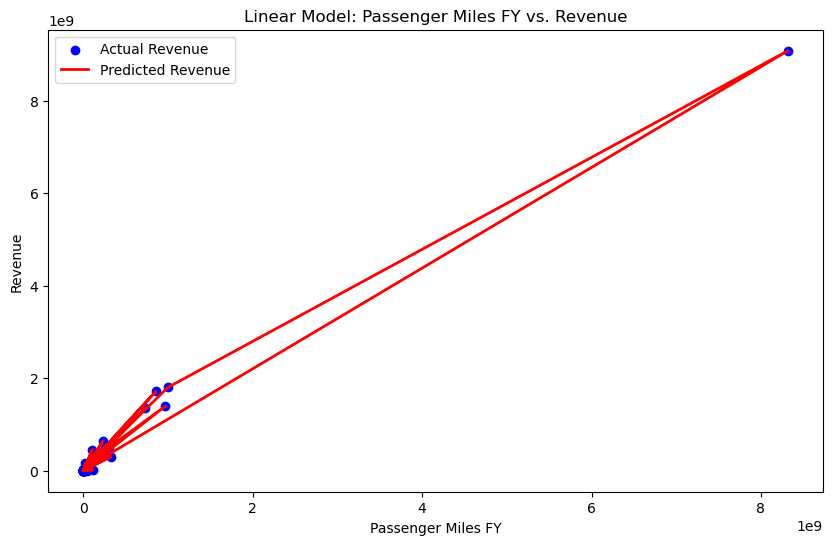

"\n#unlinked Passenger Trips FY\nX = linear_test_x[:, 1].reshape(-1, 1)\nx_delta = np.linspace(X.min(), X.max(), X.shape[0])\n\nplt.figure(figsize=(10, 6))\nplt.scatter(linear_test_x[:, 1], linear_test_y, color='blue', label='Actual Revenue')\nplt.plot(x_delta, y_delta, color='red', linewidth=2, label='Predicted Revenue')\nplt.title('Regression Tree: Unlinked Passenger Trips FY vs. Revenue')\nplt.xlabel('Unlinked Passenger Trips FY')\nplt.ylabel('Revenue')\nplt.legend()\nplt.show()\n\n#Fares FY\nX = linear_test_x[:, 2].reshape(-1, 1)\nx_delta = np.linspace(X.min(), X.max(), X.shape[0])\n\nplt.figure(figsize=(10, 6))\nplt.scatter(linear_test_x[:, 2], linear_test_y, color='blue', label='Actual Revenue')\nplt.plot(x_delta, y_delta, color='red', linewidth=2, label='Predicted Revenue')\nplt.title('Linear Model: Fares FY vs. Revenue')\nplt.xlabel('Fares FY')\nplt.ylabel('Revenue')\nplt.legend()\nplt.show()\n\n#Operating Expenses FY\nX = linear_test_x[:, 3].reshape(-1, 1)\nx_delta = np.linspa

In [75]:
#Passenger Miles FY
plt.figure(figsize=(10, 6))
plt.scatter(linear_test_x[:, 0], linear_test_y.reshape(1, -1), color='blue', label='Actual Revenue')
plt.plot(linear_test_x[:, 0], pred_revenue_linear.reshape(1, - 1)[0], color='red', linewidth=2, label='Predicted Revenue')
plt.title('Linear Model: Passenger Miles FY vs. Revenue')
plt.xlabel('Passenger Miles FY')
plt.ylabel('Revenue')
plt.legend()
plt.show()

'''
#unlinked Passenger Trips FY
X = linear_test_x[:, 1].reshape(-1, 1)
x_delta = np.linspace(X.min(), X.max(), X.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(linear_test_x[:, 1], linear_test_y, color='blue', label='Actual Revenue')
plt.plot(x_delta, y_delta, color='red', linewidth=2, label='Predicted Revenue')
plt.title('Regression Tree: Unlinked Passenger Trips FY vs. Revenue')
plt.xlabel('Unlinked Passenger Trips FY')
plt.ylabel('Revenue')
plt.legend()
plt.show()

#Fares FY
X = linear_test_x[:, 2].reshape(-1, 1)
x_delta = np.linspace(X.min(), X.max(), X.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(linear_test_x[:, 2], linear_test_y, color='blue', label='Actual Revenue')
plt.plot(x_delta, y_delta, color='red', linewidth=2, label='Predicted Revenue')
plt.title('Linear Model: Fares FY vs. Revenue')
plt.xlabel('Fares FY')
plt.ylabel('Revenue')
plt.legend()
plt.show()

#Operating Expenses FY
X = linear_test_x[:, 3].reshape(-1, 1)
x_delta = np.linspace(X.min(), X.max(), X.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(linear_test_x[:, 3], linear_test_y, color='blue', label='Actual Revenue')
plt.plot(x_delta, y_delta, color='red', linewidth=2, label='Predicted Revenue')
plt.title('Linear Model: Operating Expenses FY vs. Revenue')
plt.xlabel('Operating Expenses FY')
plt.ylabel('Revenue')
plt.legend()
plt.show()
'''

In [7]:
from sklearn.tree import plot_tree
# Plotting the decision tree for Unlinked Passenger Trips FY vs. Revenue
plt.figure(figsize=(20, 15))
plot_tree(upt_vs_revenue, filled=True, feature_names=['Unlinked Passenger Trips FY'], fontsize=6)
plt.title('Decision Tree for Unlinked Passenger Trips FY vs. Revenue')
plt.show()

NameError: name 'upt_vs_revenue' is not defined

<Figure size 2000x1500 with 0 Axes>

In [ ]:
'''
for feat in high_correlation_feats:
    current_feat = df[feat].to_numpy().reshape(-1, 1)
    linear_model = LinearRegression()
    scores = cross_validate(linear_model, current_feat, revenues, cv = 10, scoring = 'neg_mean_absolute_error')
    print('Mean absolute error for linear regressor on ', feat, ' and Revenue: ', np.average(scores['test_score']))
    
    tree_model = DecisionTreeRegressor()
    scores = cross_validate(tree_model, current_feat, revenues, cv = 10, scoring = 'neg_mean_absolute_error')
    print('Mean absolute error for regression tree on ', feat, ' and Revenue: ', np.average(scores['test_score']))
    print()

'''